In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import time, timedelta, datetime, date
from math import radians, cos, sin, asin, sqrt

In [59]:
def to_time(strtime):
    return time.fromisoformat(strtime)

def to_date(strtime):
    return datetime.combine(date(2000,1,1),to_time(strtime))

def add_date(strtime):
    return f"2017-01-01 {strtime}"
    
def get_station_y(int_num):
    global stations_dict
    return stations_dict[int_num]

def get_stop_name(stop_id):
    return stops[stops['stop_id']==stop_id]['stop_name'].to_numpy()[0][::-1]

def filter_data(data, column, filter_by):
    """returns filtered data by the specified column and list
    
    Args:
        data (pd.dataframe)
        column (str)
        filter_by (list)
    """
    if type(filter_by)==str or type(filter_by)==float or type(filter_by)==int:
        return data[data[column]==filter_by]
    return data[data[column].isin(filter_by)]

def coord_distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [60]:
def stop_dist_from_stops(sp_stop_id):
    stop_distaces_diff = [0]
    for s in range(len(sp_stop_id)-1):
        cur_stop = filter_data(stops,'stop_id',sp_stop_id[s])
        next_stop = filter_data(stops,'stop_id',sp_stop_id[s+1])
        lat1 = cur_stop.stop_lat
        lon1 = cur_stop.stop_lon
        lat2 = next_stop.stop_lat
        lon2 = next_stop.stop_lon
        if list(next_stop.stop_id==37388)[0]:
            cd = 0
        else:
            cd = coord_distance(lat1, lat2, lon1, lon2)
        stop_distaces_diff.append(cd)

    stop_distaces = []
    for s in range(len(stop_distaces_diff)):
        stop_distaces.append(sum(stop_distaces_diff[:s+1]))
    return stop_distaces


In [61]:
folder = 'gtfs_rail_only'

In [83]:
# finding the right trip_ids for the graph

control_stop = [37362, 37360, 37358, 37350, 37292, 37306, 42286]
control_stop.reverse()

sp_stop_id   = [37362, 37360, 37358, 37350, 37292, 37306, 42286]
sp_stop_id.reverse()

weekday = 'wednesday'

direction = 0 # 0 for northbound 1 for southbound anything else for both

hashron_loop_stop_ids = [37296, 37302, 37304, 37352, 37354, 37356, 42416, 42417]

In [84]:
stop_times = pd.read_csv(f"{folder}/stop_times.txt")
stop_times1 = stop_times
trips = pd.read_csv(f"{folder}/trips.txt")
calendar = pd.read_csv(f"{folder}/calendar.txt")
stops = pd.read_csv(f"{folder}/stops.txt")

A3_trip_id = filter_data(stop_times,'stop_id',control_stop).trip_id.drop_duplicates().to_numpy()

In [85]:
stops = stops[stops['stop_id'].isin(sp_stop_id)]
stops

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type,parent_station,zone_id
1,37292,17104,תל אביב ההגנה,NaN,32.053978,34.784839,0,NaN,NaN
8,37306,17090,נתב''ג,NaN,32.000360,34.870481,0,NaN,NaN
28,37350,17046,השלום,NaN,32.073346,34.793256,0,NaN,NaN
32,37358,17038,תל אביב מרכז,NaN,32.083715,34.798247,0,NaN,NaN
33,37360,17036,תא אוניברסיטה,NaN,32.103516,34.804499,0,NaN,NaN
34,37362,17034,הרצליה,NaN,32.163558,34.817406,0,NaN,NaN
61,42286,17118,ירושלים/יצחק נבון,NaN,31.788062,35.202545,0,NaN,NaN


In [86]:

trips = trips[trips['trip_id'].isin(A3_trip_id)]
A3_service_id = trips.service_id.drop_duplicates().to_numpy()


A3_calendar = calendar[calendar['service_id'].isin(A3_service_id)]
A3_service_id = A3_calendar[A3_calendar[weekday]==1].service_id.drop_duplicates().to_numpy()

trips = trips[trips['service_id'].isin(A3_service_id)]
trips = trips[trips['direction_id']==direction]

In [87]:
sp_trip_id = list(trips.trip_id.drop_duplicates().to_numpy())

stop_times = stop_times[stop_times['trip_id'].isin(sp_trip_id)]
stop_times = filter_data(stop_times,'stop_id',sp_stop_id)

In [88]:
to_remove = []
for i in sp_trip_id:
    if len(list(filter_data(stop_times,'trip_id',i).trip_id.to_numpy()))<2:
        to_remove.append(i)

# filter out the trains on hasharon loop without filtering out the trains to jerusalem
for i in sp_trip_id:
    d = filter_data(stop_times1,'trip_id',i)
    stop_list = list(d.stop_id.to_numpy())
    flag_sharon = False
    for j in stop_list:
        if j in hashron_loop_stop_ids:
            flag_sharon = True
    if flag_sharon:
        if i not in to_remove:
            to_remove.append(i)

for j in to_remove:
    sp_trip_id.remove(j)

In [89]:
len(sp_trip_id)

167

In [90]:
#stop_distaces = [0, 11.4, 17.3, 19.1, 24.3, 24.3, 26.7, 28.7, 29.8, ] #מעתלית צפונה
stop_distaces = stop_dist_from_stops(sp_stop_id)

stop_names = [get_stop_name(i) for i in sp_stop_id]

stations_dict = dict(zip(sp_stop_id,stop_distaces))

In [91]:
start_time = '00:00:00'
end_time   = '23:59:00'

In [92]:
T0 = to_date(stop_times.departure_time.min())

C:\Users\Eithan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


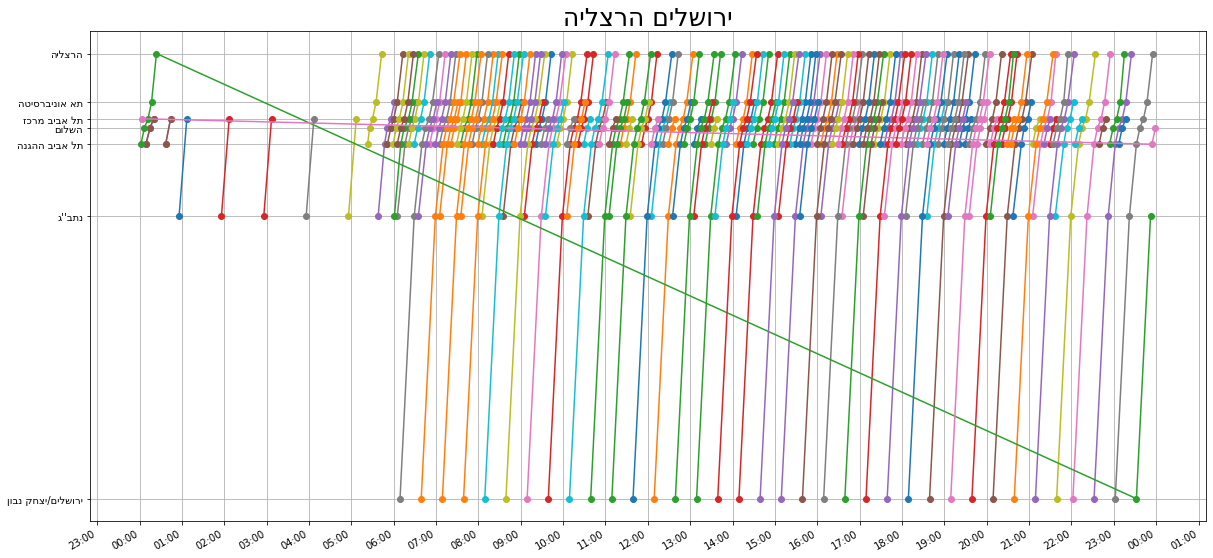

In [96]:
for i in sp_trip_id:
    current_line = stop_times[stop_times['trip_id']==i]
    current_line = current_line[current_line['stop_id'].isin(sp_stop_id)]
    departure_time = current_line['departure_time'].apply(to_date).to_numpy()
    stop_ids = current_line['stop_id'].apply(get_station_y).to_numpy()
    plt.plot(departure_time,stop_ids,marker='o')


bx = plt.axes()
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M')
bx.xaxis.set_major_locator(hours)
bx.xaxis.set_major_formatter(h_fmt)

title = 'ירושלים הרצליה'
plt.title(label=title[::-1],fontsize=25)

#plt.xlim(to_date(start_time),to_date(end_time))

plt.gcf().autofmt_xdate()
plt.yticks(stop_distaces,stop_names)
plt.rc('figure', figsize=(20, 10))
plt.grid()

plt.show()

